In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF

In [2]:
DIR_PATH = "../datasets/thor_magni_pub_ready/"
VISUALS_PATH = "../datasets/thor_magni_pub_ready/maps/"
SCENARIO_ID = "Scenario_3"
FILE_NAME = "THOR-Magni_180522_SC3A_R1.csv"

In [3]:
raw_df, header_dict = load_csv_metadata_magni(
    os.path.join(DIR_PATH, SCENARIO_ID, FILE_NAME)
)

In [4]:
new_header_dict = preprocessing_header_magni(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

### Filtering best markers

In [5]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [6]:
best_markers_traj[["x", "y"]] /= 1000 # to m

### Helper pix <-> m 

In [7]:
class PixWorldConverter:
    """Pixel to world converter"""

    def __init__(self, info: dict) -> None:
        self.resolution = info["resolution_pm"]  # 1pix -> m
        self.offset = np.array(info["offset"])

    def convert2pixels(self, world_locations: np.array) -> np.array:
        if world_locations.ndim == 2:
            return (world_locations / self.resolution) - self.offset

        new_world_locations = [
            self.convert2pixels(world_location) for world_location in world_locations
        ]
        return np.stack(new_world_locations)

    def convert2world(self, pix_locations: np.array) -> np.array:
        return (pix_locations + self.offset) * self.resolution

In [8]:
info = {"resolution_pm" : 0.01, "offset": [-860, -1050]} # play with offset
pix2world_converter = PixWorldConverter(info)

In [9]:
vis_path = os.path.join(VISUALS_PATH, "OCC1805_Clean.png")
img = Image.open(vis_path)
targ_img = np.array(img)
map_layout  = np.flipud(targ_img[:,:,:3])

# Plot trajectories

In [10]:
best_markers_traj = best_markers_traj.copy()
best_markers_traj.loc[:, ["x_px", "y_px"]] = pix2world_converter.convert2pixels(
    best_markers_traj[["x", "y"]].values
)

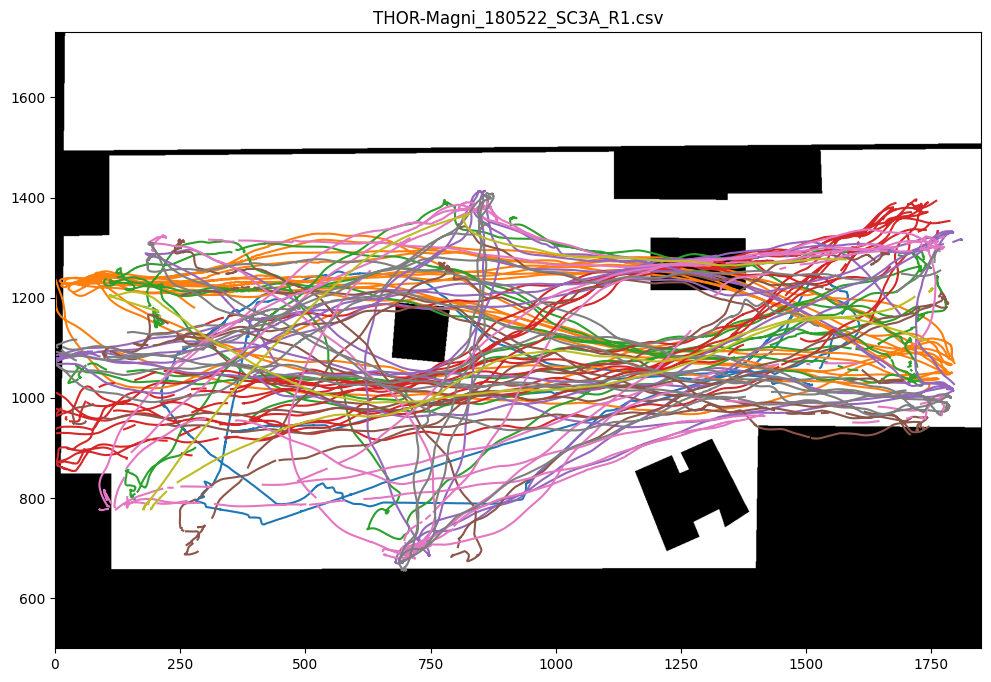

In [11]:
plt.figure(figsize=(16, 8))
plt.title(FILE_NAME);
plt.imshow(map_layout);
for agent_id in best_markers_traj.ag_id.unique():
    traj_agent = best_markers_traj[best_markers_traj["ag_id"] == agent_id]
    label = agent_id + f" ({roles[agent_id]})" if roles else ""
    plt.plot(traj_agent["x_px"], traj_agent["y_px"], label=label)
plt.xlim([0, 1850]);
plt.ylim([500, 1730]);